In [1]:
import numpy as np
import matplotlib.pyplot as pyplot

# The Curious Case of Population Variance

Let's remind ourselves about the definition of variance: 

$$ \text{Var}(X) = E[ (X - \mu)^2 ] $$

That is, it's the expected difference squared between an random variable $X$ and its mean, $\mu$.
This is Prob 'n Stats Day 1 stuff.

Obviously, in most situations we don't actually know the parameters of our probability
distribution. Instead we have some sample data $X_1, \ldots, X_n$. With our sample population,
we try to estimate the parameters of our PDF. The most obvious example is estimating $\mu$:

$$ \overline{X} = \frac{1}{n} \sum_{i=1}^n X_i $$

I would also guess that the average person would estimate variance in more-or-less the same way

$$ s^2_n = \frac{1}{n} \sum_{i=1}^n (X_i - \overline{X})^2 $$

And that person (like me) might be shocked to learn that $s^2_n$ (the *uncorrected sample variance*) **is
a biased estimator!** It will, in fact, consistently *underestimate* the true variance of the
population! Allow me to demonstrate...

In [2]:
# `samples` is 100000 rows of 50 columns, each drawn from a
# normal distribution with μ = 0 and σ^2 = 1.
#
# Each row is represents an experiment with 50 observations
samples = np.random.normal(0, 1, (50, 100000))

In [3]:
def uncorrected_variance(sample):
    """ Given a sample populations, computes the uncorrected
    sample variance:

    s^2_n = (1 / n) Sum( (x_i - μ)^2 )
    """
    n = sample.size
    μ = sample.mean()
    s = np.sum(np.vectorize(lambda xi: (xi - μ)**2)(sample)) / n
    return s

In [4]:
s_uncorrected = np.apply_along_axis(uncorrected_variance, 0, samples)

In [5]:
def plot_variance_exp(variances, true_μ=1):
    mean = variances.mean()
    lbl = str.format("Mean: {0:.4f}\nBiase: {1:.4f}", mean, mean - true_μ)
    pyplot.hist(variances, bins=25, alpha=0.5)
    pyplot.axvline(mean, color='b', linestyle='dashed')
    pyplot.text(x=1.5, y=10000, s=lbl)
    return None

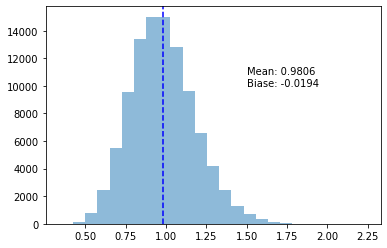

In [6]:
plot_variance_exp(s_uncorrected)

**After running 100,000 experiments, being off by 2% sure seems like a lot!** And again, it's not just wrong, but consistently too small!

## Correcting the Bias

Before we get to *why* $s^2_n$ is biased, let's actually start with the correction,
and work backwards from there. As it happens, $s^2_n$ will be off by a factor of $\frac{n}{n - 1}$. 
This factor is known as *Bessel's correction* (what a guy, Bessel...). Scaling up
the uncorrected variance estimation by this factor gives us our corrected (and unbiased)
variance estimator, $s^2_{n-1}$.

$$ s^2_{n - 1} = \frac{n}{n - 1} s^2_n = \frac{1}{n -1} \sum_{i=1}^n (X_i - \overline{X})^2 $$

This new estimator is unbaised --- I wouldn't lie to you about that! But let's run another
experiment, just to make ourselves feel better.

In [7]:
def bessel_variance(sample):
    """Given a sample population, computes the corrected
    sample variance:

    s^2_(n-1) = (1 / (n - 1)) Sum( (x_i - μ)^2 )
    """
    n = sample.size
    μ = sample.mean()
    s = np.sum(np.vectorize(lambda xi: (xi - μ)**2)(sample)) / (n - 1)
    return s

In [8]:
s_corrected = np.apply_along_axis(bessel_variance, 0, samples)

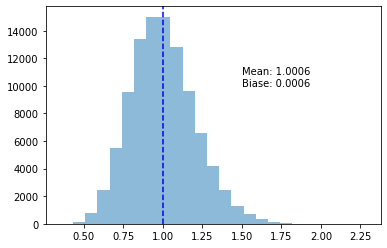

In [9]:
plot_variance_exp(s_corrected)

That's more like it, huh! Now we're seeing $\overline{s^2_{n-1}}$ being within 0.01% of the true $\text{Var}(X)$.

## So... What Just Happened?

I have to admit, this kinda blew me away at first. I just happened to read somewhere "of course, the naive $s^2_n$ estimator is biased", and had to do a double take. I even pulled out my university Prob & Stats textbook to see if we learned this (as it happens, the book just defines $s^2_{n-1}$, and says you should use that on the problem sets with no explanation...)

It is a very well known correction, though; I just seem to have missed the memo.

Luckily, though, it's actually pretty simple to explain what went wrong with $s^2_n$. To start, I'll give a high-level explanation for the source of our bias.

### High-Level Problem

There are two terms used to describe how "far-off" some $X_i$ was from the "theoretical value". 

|                 |                             |
|-----------------|-----------------------------|
| **Errors:**     | $e_i = X_i - \mu$           |
| **Residuals:**  | $r_i = X_i - \overline{X}$ |

Often in experiments, the true $\mu$ is unknown to us, and we are forced to estimate it with $\overline{X}$. This means, in an experiment, we can measure the residuals but we **may not be able to measure the errors.**

Because $\text{Var}(X) = E[ (X - \mu)^2 ]$, *variance is the expected value of the sum of the squared errors.* But we didn't know the errors! We used the residuals instead. How well would things have worked if we knew the true errors, and not just the residuals?

In [10]:
def error_variance(sample):
    """ Given a sample populations, computes the sample variance
    as the MSE. To measure the errors, we must know that μ=0.

    s^2_n = (1 / n) Sum( (x_i - μ)^2 )
    """
    n = sample.size
    μ = 0
    s = np.sum(np.vectorize(lambda xi: (xi - μ)**2)(sample)) / n
    return s

In [11]:
s_errors = np.apply_along_axis(error_variance, 0, samples)

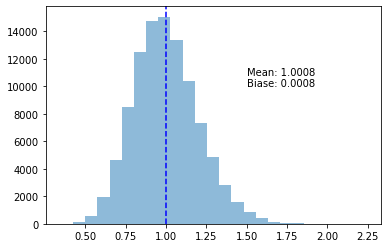

In [12]:
plot_variance_exp(s_errors)

This, in fact, gives us an unbiased estimator! **So obviously the secret lies in the difference between errors and residuals.**

$X_i - \mu$ and $X_i - \overline{X}$ don't seem that different, especially considering $\overline{X}$ is an estimator for $\mu$. As an estimator, though, $\overline{X}$ is itself a random variable. The crux is that $X_i$ and $\overline{X}$ **are not independent variables!** A small part of $X_i$ is "inside" $\overline{X}$. So even though we are adding $n$ terms together, we actually only have $n-1$ degrees of freedom between those terms.

Put even more exactly, our uncorrected estimator is being drawn from a chi-squared distribution with only $n-1$ degrees of freedom.

$$ \frac{1}{\sigma^2} \sum r_i^2 \sim \chi^2_{n-1} $$

### But Where is the Bias Coming From?

Once we realize that the relationship between any $X_i$ and $\overline{X}$, we can quickly break things down and see where this bias is coming from. We've already noted that the true variance can be estimated as $\frac{1}{n} \sum_i e_i^2$. We're going to be using the residuals, however, which begs the question "what's the relationship between $e_i$ and $r_i$?"

$$ e_i = \underbrace{(X_i - \overline{X})}_{r_i} + (\overline{X} - \mu) $$

$$
\begin{align*}
  \frac{1}{n} \sum_i e_i^2 &= \frac{1}{n} \sum_i (r_i + (\overline{X} - \mu))^2\\
  &= \frac{1}{n} \sum_i \left (r_i^2 + 2r_i(\overline{X} - \mu) + (\overline{X} - \mu)^2 \right )\\
  &= \frac{1}{n} \left[ \sum_i \left( r_i^2 \right) + 2 \sum_i \left( r_i(\overline{X} - \mu) \right) + n(\overline{X} - \mu)^2 \right]
\end{align*}
$$

The first term is our "uncorrected estimator" (the mean of the residuals, rather than the errors). I want to dive into the middle term quickly, where we will see this interaction between $X_i$ and $\overline{X}$ play out.

$$
\begin{align*}
    \sum_i r_i(\overline{X} - \mu) &= \sum_i (X_i - \overline{X})(\overline{X} - \mu)\\
    &= \sum_i \left( \overline{X}X_i - X_i\mu - \overline{X}^2 + \overline{X}\mu \right)\\
    &= \overline{X} \sum X_i - \mu \sum X_i - n \overline{X}^2 + n\mu\overline{X}\\
\end{align*}
$$

Now, of course $\overline{X} = \frac{1}{n} \sum X_i$...

$$
\begin{align*}
    &= n \overline{X}^2 - n\mu\overline{X} - n\overline{X}^2 + n\mu\overline{X}\\
    &= 0
\end{align*}
$$

Finally, we are left with a big fat bias staring back at us...

$$
\begin{align*}
    \frac{1}{n} \sum e_i &= \frac{1}{n} \sum r_i^2 + (\overline{X} - \mu)^2\\
    &= s^2_n + (\overline{X} - \mu)^2
\end{align*}
$$

### How Does $n - 1$ Fix This?

Well, we know that $E\left[ \frac{1}{n} \sum e_i \right] = \sigma^2$, right? Then let's take a look at the last line from above...

$$
\begin{align*}
    E\left[ \frac{1}{n} \sum e_i \right] &= E[s^2_n] + E[(\overline{X} - \mu)^2]\\
    \sigma^2 &= E[s^2_n] + \frac{\sigma^2}{n}\\
    E[s^2_n] &= \frac{n - 1}{n} \sigma^2
\end{align*}
$$

And there it is! Simply scaling up by $\frac{n}{n - 1}$ will yield an unbiased estimator!

## So Always Use $s^2_{n-1}$?

That sure would make life simple, huh? Well I have bad news --- the unbiased estimator will, in fact, yield a worse *mean squared error.* Here's another simulation to demonstrate.

In [13]:
def MSE(estimates, θ=1):
    """Calculates the MSE of a set of estimates against a known θ."""
    n = estimates.size
    mse = np.sum(np.vectorize(lambda ti: (ti - θ)**2)(estimates)) / (n)
    return mse

In [14]:
mse_uncorrected, mse_corrected = MSE(s_uncorrected), MSE(s_corrected)
print("Uncorrected MSE:  " + str(mse_uncorrected))
print("Corrected MSE:    " + str(mse_corrected))
print("Percent Increase: " +
      str(100 * (mse_corrected - mse_uncorrected) / mse_uncorrected))

Uncorrected MSE:  0.039765490470560265
Corrected MSE:    0.04101443329481074
Percent Increase: 3.1407705763747864


## The MSE of Variance Estimators

A 4% increase in MSE... we just can't win, can we!? 

> "So to minimize bias use $s^2_{n-1}$, and to minimize error use $s^2_n$?"

My friend, meet $s^2_{n+1}$...

In [15]:
def mse_min_variance(sample):
    """Given a sample population, computes the sample variance,
    minimizing the MSE (for a normal distribution).

    s^2_(n+1) = (1 / (n + 1)) Sum( (x_i - μ)^2 )
    """
    n = sample.size
    μ = sample.mean()
    s = np.sum(np.vectorize(lambda xi: (xi - μ)**2)(sample)) / (n + 1)
    return s

In [16]:
s_mse_min = np.apply_along_axis(mse_min_variance, 0, samples)

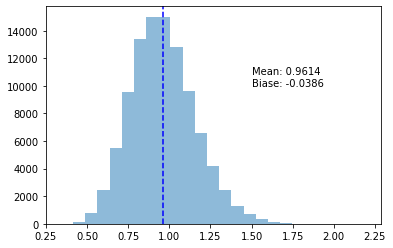

In [17]:
plot_variance_exp(s_mse_min)

In [18]:
MSE(s_mse_min)

0.03935094118106912

As it happens, for a normal distribution, $s^2_{n + 1}$ will minimize our MSE. As is often the case in modeling and statistics, we have a trade-off to consider. Should we minimize the bias, or the MSE?

I should warn you, however, **$s^2_{n+1}$ will only minimize the MSE with a normal distribution.** Different distributions will have their own optimal error-reducing estimators. Answering "why" is really a matter of crunching the numbers --- I don't think I can explain it better than [Wikipedia does](https://en.wikipedia.org/wiki/Mean_squared_error#Variance), but for completeness sake, let's put the results here.

We can take a variance estimator $s^2_a = \frac{1}{a} \sum (X_i - \overline{X})$, and calculate it's MSE. This works out to (just trust me on this one):

$$
\text{MSE}(s^2_a) = \frac{n - 1}{na^2} ((n - 1) \gamma_2 + n^2 + n)\sigma^4 - 2 \left( \frac{n-1}{a} \right) \sigma^4 + \sigma^4
$$

A bit of a mouthful, but ok. $\gamma_2$ here, by the way, is the *excess kurtosis* of this distribution (a measure of how "tailed" a distribution is). This is the kind of number that you could easily find for any distribution.

Now, to find the optimal $s^2_a$ for some distribution, we simply minimize the MSE function, which happens when

$$
a = n + 1 + \frac{n - 1}{n} \gamma_2
$$

The normal distribution has $\gamma_2 = 0$, which is where our $a = n + 1$ is coming from. If we were drawing from a Bernoilli distribution, however, $\gamma_2 = -2$, and we'd find $a = n - 1 + \frac{2}{n}$.

## That's All, Fokes!

It's when the most mundane things don't work as you'd expect that always seem the most exciting. I *might* be the last person to have gotten the memo on variance estimation. If not, though, I hope some of you were just as take by it as me.

Thanks for reading, and as always, leave a comment, and let me know your thoughts, questions, or comments!